# Deep learning project

## Kunskapskontroll 2

### Detecting emotion on images or video of human faces.

To start with we use the following dataset from Kaggle:

'Face expression recognition dataset'

LINK:
https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

Supplemental dataset from :
    
http://mmlab.ie.cuhk.edu.hk/projects/socialrelation/index.html

The project is based on the example from this Github: https://github.com/akmadan/Emotion_Detection_CNN
 and the Youtube video: https://www.youtube.com/watch?v=Bb4Wvl57LIk

## Importing libraries

In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from datetime import datetime
import os
import itertools
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array,  load_img
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D


from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator 
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model,Sequential
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input #preprocesses the input image to align with the preprocessing used for training the VGG16 model on ImageNet data.
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

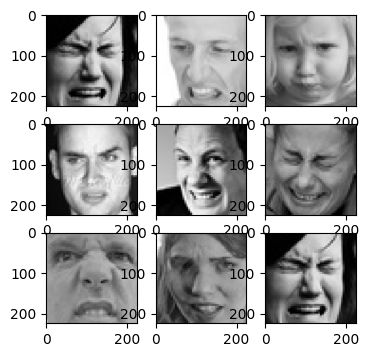

In [5]:
expression = 'disgust'

plt.figure(figsize= (4,4))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img("content/train/"+expression+"/"+
                  os.listdir("content/train/" + expression)[i], target_size=(224, 224))
    plt.imshow(img)   
plt.show()

## Making Training and Validation Data

In [6]:
expressions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

### We need to make training and validation sets. and make sure images are proper size etc.

80% of the images for training and 20% for validation.

In [7]:
train_path = 'content/train'
test_path = 'content/validation'

In [8]:
IMAGE_SIZE = [224, 224]
batch_size = 32

### Test data path.

In [9]:
folders = glob('content/train/*')
print(len(folders))

7


### Preprocess data

In [10]:
import tensorflow as tf

# Define a generator function to load and preprocess the data
def data_generator(dataset, preprocess_fn):
    for image_batch, label_batch in dataset:
        yield preprocess_fn(image_batch, label_batch)

# Load the dataset without preprocessing
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255
)

train_datagen = datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

test_datagen = datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 23060 images belonging to 7 classes.
Found 1411 images belonging to 7 classes.


In [11]:
# Function to limit and repeat the dataset
def limit_and_repeat_dataset(generator, desired_size, num_repeats):
    images, labels = [], []
    for _ in range(num_repeats):
        for image_batch, label_batch in generator:
            if len(images) < desired_size:
                images.extend(image_batch)
                labels.extend(label_batch)
            else:
                break
    
    # Combine images and labels into a tuple
    limited_dataset = (tf.convert_to_tensor(images[:desired_size]),
                       tf.convert_to_tensor(labels[:desired_size]))
    
    return limited_dataset

# Desired sizes for the limited datasets
desired_train_size = 4800
desired_val_size = 1200
desired_test_size = 1411

# Calculate the number of repeats needed to achieve the desired sizes
num_repeats_train = int(desired_train_size / len(train_datagen))
num_repeats_val = int(desired_val_size / len(train_datagen))
num_repeats_test = int(desired_test_size / len(test_datagen))

# Create limited and repeated datasets
limited_repeated_train_dataset = limit_and_repeat_dataset(train_datagen, desired_train_size, num_repeats_train)
limited_repeated_val_dataset = limit_and_repeat_dataset(train_datagen, desired_val_size, num_repeats_val)
limited_repeated_test_dataset = limit_and_repeat_dataset(test_datagen, desired_test_size, num_repeats_test)

# Print the shapes of the limited and repeated datasets
print("Limited and repeated train dataset shape:", limited_repeated_train_dataset[0].shape)
print("Limited and repeated val dataset shape:", limited_repeated_val_dataset[0].shape)
print("Limited and repeated test dataset shape:", limited_repeated_test_dataset[0].shape)


Limited and repeated train dataset shape: (4800, 224, 224, 3)
Limited and repeated val dataset shape: (1200, 224, 224, 3)
Limited and repeated test dataset shape: (1411, 224, 224, 3)


In [13]:
'''
import tensorflow as tf

# Function to limit and repeat the dataset
def limit_and_repeat_dataset(generator, desired_size, num_repeats):
    images, labels = [], []
    for _ in range(num_repeats):
        for image_batch, label_batch in generator:
            if len(images) < desired_size:
                images.extend(image_batch)
                labels.extend(label_batch)
            else:
                break
    
    # Combine images and labels into a tuple
    limited_dataset = (tf.convert_to_tensor(images[:desired_size]),
                       tf.convert_to_tensor(labels[:desired_size]))
    
    return limited_dataset

# Desired size for the limited dataset
desired_size = 6000

# Number of times to repeat the dataset to achieve the desired size
num_repeats_train = desired_size // len(train_datagen)
num_repeats_val = desired_size // len(val_datagen)
num_repeats_test = desired_size // len(test_datagen)

# Create limited and repeated datasets
limited_repeated_train_dataset = limit_and_repeat_dataset(train_datagen, desired_size, num_repeats_train)
limited_repeated_val_dataset = limit_and_repeat_dataset(val_datagen, desired_size, num_repeats_val)
limited_repeated_test_dataset = limit_and_repeat_dataset(test_datagen, desired_size, num_repeats_test)

# Print the shapes of the limited and repeated datasets
print("Limited and repeated train dataset shape:", limited_repeated_train_dataset[0].shape)
print("Limited and repeated val dataset shape:", limited_repeated_val_dataset[0].shape)
print("Limited and repeated test dataset shape:", limited_repeated_test_dataset[0].shape)
'''


'\nimport tensorflow as tf\n\n# Function to limit and repeat the dataset\ndef limit_and_repeat_dataset(generator, desired_size, num_repeats):\n    images, labels = [], []\n    for _ in range(num_repeats):\n        for image_batch, label_batch in generator:\n            if len(images) < desired_size:\n                images.extend(image_batch)\n                labels.extend(label_batch)\n            else:\n                break\n    \n    # Combine images and labels into a tuple\n    limited_dataset = (tf.convert_to_tensor(images[:desired_size]),\n                       tf.convert_to_tensor(labels[:desired_size]))\n    \n    return limited_dataset\n\n# Desired size for the limited dataset\ndesired_size = 6000\n\n# Number of times to repeat the dataset to achieve the desired size\nnum_repeats_train = desired_size // len(train_datagen)\nnum_repeats_val = desired_size // len(val_datagen)\nnum_repeats_test = desired_size // len(test_datagen)\n\n# Create limited and repeated datasets\nlimite

# VGG16 model preparation and eda

In [14]:
# Load the VGG16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [15]:
# shape and structure of the input data that should be fed into the model during training or inference. 
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [16]:
# shape and structure of the output data that will be the result.
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

### We only want the first layers of the bgg16 model

In [17]:
layers = 10

# Extract the first 10 layers from the base model
desired_layers = vgg.layers[:layers]

# Create a new model with only the desired layers
vgg_partial = Model(inputs=vgg.input, outputs=desired_layers[-1].output)

In [18]:
# Freeze the layers in the partial VGG model (optional)
for layer in vgg_partial.layers:
    layer.trainable = False

### Customized model creation

In [19]:
# Custom head for classification

no_of_classes = 7

#1st CNN layer
custom_head = Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(7, 7, 512))(vgg_partial.output)
custom_head = BatchNormalization()(custom_head)
custom_head = MaxPooling2D(pool_size=(2, 2))(custom_head)
custom_head = Dropout(0.25)(custom_head)

#2nd CNN layer
custom_head = Conv2D(128, (5, 5), padding='same', activation='relu')(custom_head)
custom_head = BatchNormalization()(custom_head)
custom_head = MaxPooling2D(pool_size=(2, 2))(custom_head)
custom_head = Dropout(0.25)(custom_head)

#3rd CNN layer
#custom_head = Conv2D(512, (3, 3), padding='same', activation='relu')(custom_head)
#custom_head = BatchNormalization()(custom_head)
#custom_head = MaxPooling2D(pool_size=(2, 2))(custom_head)
#custom_head = Dropout(0.25)(custom_head)

#4th CNN layer
#custom_head = Conv2D(512, (3, 3), padding='same', activation='relu')(custom_head)
#custom_head = BatchNormalization()(custom_head)
#custom_head = MaxPooling2D(pool_size=(2, 2))(custom_head)
#custom_head = Dropout(0.25)(custom_head)

# Flatten the output for fully connected layers
custom_head = Flatten()(custom_head)

# Fully connected 1st layer
custom_head = Dense(256, activation='relu')(custom_head)
custom_head = BatchNormalization()(custom_head)
custom_head = Dropout(0.25)(custom_head)

# Fully connected 2nd layer
custom_head = Dense(512, activation='relu')(custom_head)
custom_head = BatchNormalization()(custom_head)
custom_head = Dropout(0.25)(custom_head)

# Last layer
custom_head = Dense(no_of_classes, activation='softmax')(custom_head)


In [20]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='hybrid_vgg16_face_emotion_model.h5', verbose=2, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
callbacks = [checkpoint, early_stopping]

# timer
start = datetime.now()

# lr
adam = Adam(learning_rate=0.0001)  

In [21]:
# Combine the partial VGG model and the custom head
model = Model(name='hybrid_vgg16_face_emotion_model',inputs=vgg_partial.input, outputs=custom_head)

# Compile the model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "hybrid_vgg16_face_emotion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None,

## Fit the model and train it.

In [22]:
epochs = 48

# Unpack the dataset into X_train and y_train
X_train, y_train = limited_repeated_train_dataset

# Unpack the validation dataset into X_val and y_val
X_val, y_val = limited_repeated_val_dataset

# Check the shapes of the training data
print("Shapes of training data:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Train the model
epochs = 48
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    steps_per_epoch=500,
    validation_steps=64,
    callbacks=callbacks,
    verbose=1
)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Shapes of training data:
X_train shape: (4800, 224, 224, 3)
y_train shape: (4800, 7)
Epoch 1/48
500/500 [==============================] - ETA: 0s - loss: 2.3014 - accuracy: 0.2594
Epoch 1: val_loss improved from inf to 1.79854, saving model to hybrid_vgg16_face_emotion_model.h5


C:\Users\asche\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 360s 718ms/step - loss: 2.3014 - accuracy: 0.2594 - val_loss: 1.7985 - val_accuracy: 0.3683
Epoch 2/48
500/500 [==============================] - ETA: 0s - loss: 1.7901 - accuracy: 0.3958
Epoch 2: val_loss improved from 1.79854 to 1.69189, saving model to hybrid_vgg16_face_emotion_model.h5
500/500 [==============================] - 422s 844ms/step - loss: 1.7901 - accuracy: 0.3958 - val_loss: 1.6919 - val_accuracy: 0.4017
Epoch 3/48
500/500 [==============================] - ETA: 0s - loss: 1.5319 - accuracy: 0.4668
Epoch 3: val_loss did not improve from 1.69189
500/500 [==============================] - 424s 849ms/step - loss: 1.5319 - accuracy: 0.4668 - val_loss: 1.7786 - val_accuracy: 0.3892
Epoch 4/48
500/500 [==============================] - ETA: 0s - loss: 1.4008 - accuracy: 0.5032
Epoch 4: val_loss did not improve from 1.69189
500/500 [==============================] - 418s 836ms/step - loss: 1.4008 - accuracy: 0.5032 - val_loss: 2.061

## Plotting Accuracy & Loss

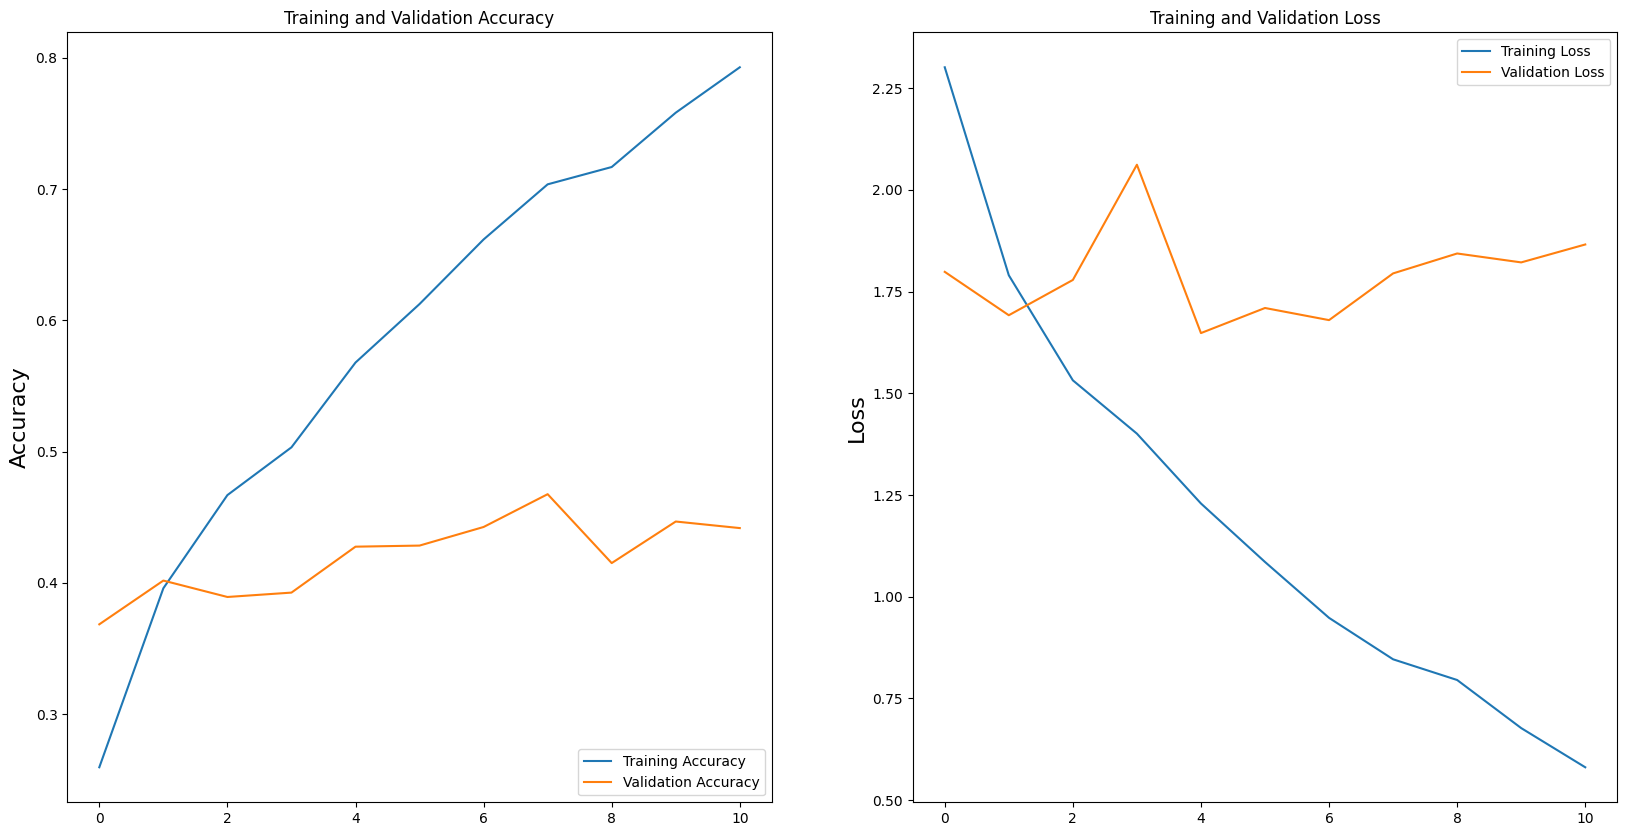

In [23]:
plt.figure(figsize=(20, 10))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


45/45 [==============================] - 64s 1s/step


<Figure size 800x800 with 0 Axes>

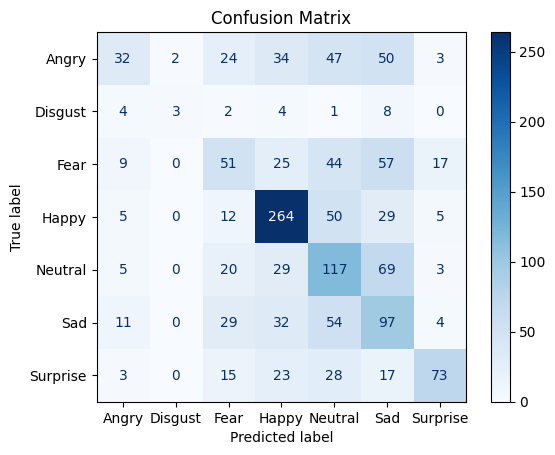

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Unpack the dataset into X_train and y_train
X_test, y_test = limited_repeated_test_dataset

# Assuming y_test contains the true labels and y_pred contains the predicted labels
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=expressions).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Evaluate the model on the test dataset

In [28]:
test_loss, test_accuracy = model.evaluate(
    x=X_train,
    y=y_train,
)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

150/150 [==============================] - 208s 1s/step - loss: 0.4276 - accuracy: 0.8750
Test Loss: 0.4276280701160431
Test Accuracy: 0.875


# Test the model

A test image from the internet : https://techhowdy.com/wp-content/uploads/2018/05/Cute-Sad-Baby-Pics-For-Whatsapp-Display-Picture-21.jpg

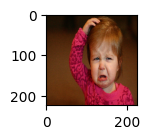

In [35]:
plt.figure(figsize= (4,4))
plt.subplot(3,3,i)
img = load_img('sad_baby.jpg', target_size=(224, 224))
plt.imshow(img)   
plt.show()

In [38]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
image_path = 'sad_baby.jpg' 
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, convert to RGB

# Resize and preprocess the image
img = cv2.resize(img, (224, 224))
img = img / 255.0  # Normalize the pixel values

# Reshape the image to match the model's input shape
img = np.reshape(img, (1, 224, 224, 3))

# Make predictions
predictions = model.predict(img)

# Assuming you have a mapping of emotion labels (e.g., ['happy', 'sad', 'angry', ...])
emotion_labels = expressions
predicted_emotion = emotion_labels[np.argmax(predictions)]

# Get the index of the maximum prediction
predicted_emotion_index = np.argmax(predictions)

# Get the corresponding emotion label
predicted_emotion = emotion_labels[predicted_emotion_index]

# Print the predicted emotion
print("Predicted Emotion:", predicted_emotion)


1/1 [==============================] - 0s 84ms/step
Predicted Emotion: Sad
